In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!ls ../data/raw/ielts

ielts_writing_dataset.csv


In [3]:
fp = '../data/raw/ielts/ielts_writing_dataset.csv'
df = pd.read_csv(fp)

In [4]:
df.sample()

,Task_Type,Question,Essay,Examiner_Commen,Task_Response,Coherence_Cohesion,Lexical_Resource,Range_Accuracy,Overall
218,1,The pie charts below show how dangerous waste ...,The bar charts illustrate five different metho...,NaN,NaN,NaN,NaN,NaN,5.5


In [5]:
df['Task_Type']==1

0        True
1       False
2        True
3       False
4        True
        ...  
1430    False
1431    False
1432    False
1433    False
1434    False
Name: Task_Type, Length: 1435, dtype: bool

In [6]:
mask1 = df['Task_Type']==1
mask2 = df['Task_Type']==2
df[mask1]['Overall'].value_counts().sort_index()

1.0      1
3.0      1
3.5      4
4.0      5
4.5     13
5.0     48
5.5    103
6.0    129
6.5    128
7.0     91
7.5     69
8.0     36
8.5     14
Name: Overall, dtype: int64

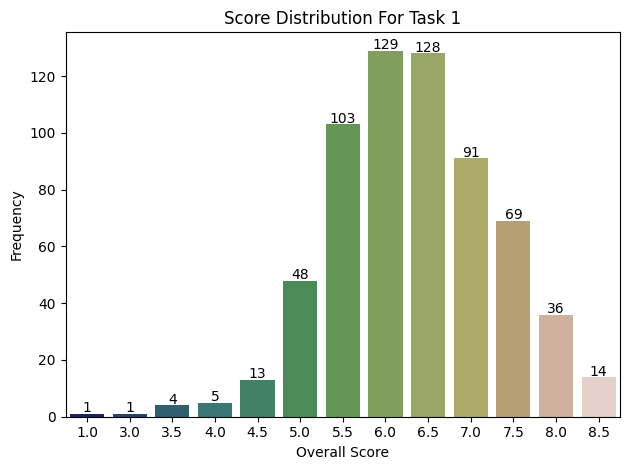

In [7]:
task1 = df[mask1]['Overall'].value_counts().sort_index()

sns.barplot(x=task1.index, y=task1.values, palette='gist_earth')

for index, value in enumerate(task1.values):
    plt.text(index, value + 0.5, str(value), ha='center')

plt.xlabel('Overall Score')
plt.ylabel('Frequency')
plt.title('Score Distribution For Task 1')
plt.savefig('../plots/IELTS_Score_Dist1.png')
plt.tight_layout()
plt.show()


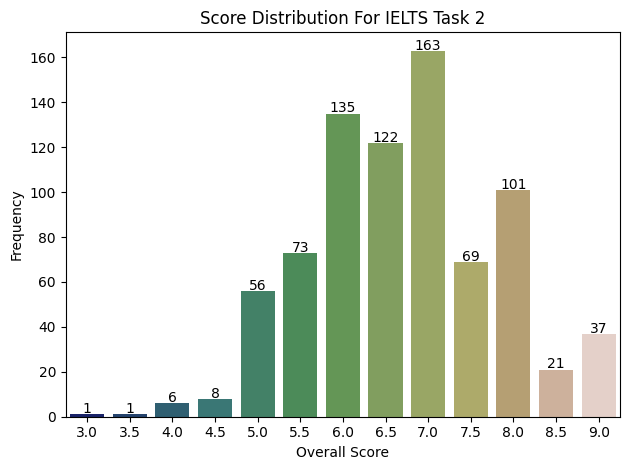

In [8]:
task2 = df[mask2]['Overall'].value_counts().sort_index()

sns.barplot(x=task2.index, y=task2.values, palette='gist_earth')

for index, value in enumerate(task2.values):
    plt.text(index, value + 0.5, str(value), ha='center')

plt.xlabel('Overall Score')
plt.ylabel('Frequency')
plt.title('Score Distribution For IELTS Task 2')
plt.savefig('../plots/IELTS_Score_Dist2.png')
plt.tight_layout()
plt.show()

# Part 2: Visualization of Feature Embeddings

In [9]:
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
sys.path.append('../src/features')
from basic_features_1 import FeatureExtractor
# from complex_features2 import ComplexFeatureExtractor
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ginger/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ginger/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [10]:
long_essays = df[mask2]
long_essays.columns

Index(['Task_Type', 'Question', 'Essay', 'Examiner_Commen', 'Task_Response',
       'Coherence_Cohesion', 'Lexical_Resource', 'Range_Accuracy', 'Overall'],
      dtype='object')

In [11]:
# long_essays.reset_index(drop=True, inplace=True)

In [12]:
feature_extractor = FeatureExtractor()

In [13]:
feature_extractor.__dict__

{'nlp': <spacy.lang.en.English at 0x7ff817397d00>,
 'sia': <nltk.sentiment.vader.SentimentIntensityAnalyzer at 0x7ff814f1ffd0>,
 'spell': <spellchecker.spellchecker.SpellChecker at 0x7ff7d1da12c0>,
 'tool': LanguageTool(language=<LanguageTag "en-US">, motherTongue=None)}

  0%|          | 0/793 [00:00<?, ?it/s]

In [23]:
# long_essays['Overall'].values

In [22]:
basic_df['Overall'] = long_essays['Overall'].values

In [68]:
basic_df[['Question', 'Essay']] =  long_essays[['Question', 'Essay']]

basic_df

In [17]:
# cols = ['Overall',
#        'word_count', 'char_count', 'avg_words_per_sentence', 'sentence_count',
#        'paragraph_count', 'spelling_mistakes', 'grammar_mistakes',
#        'avg_chars_per_word', 'avg_syllables_per_word', 'punctuation_count',
#        'unique_word_count', 'ttr', 'long_word_count', 'short_sentence_count',
#        'complex_sentence_count', 'flesch_kincaid_grade', 'coleman_liau_index']
# basic_df[cols]['Overall'].isna().sum()

/tmp/ipykernel_26742/2319561319.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(basic_df.corr(), annot=True);


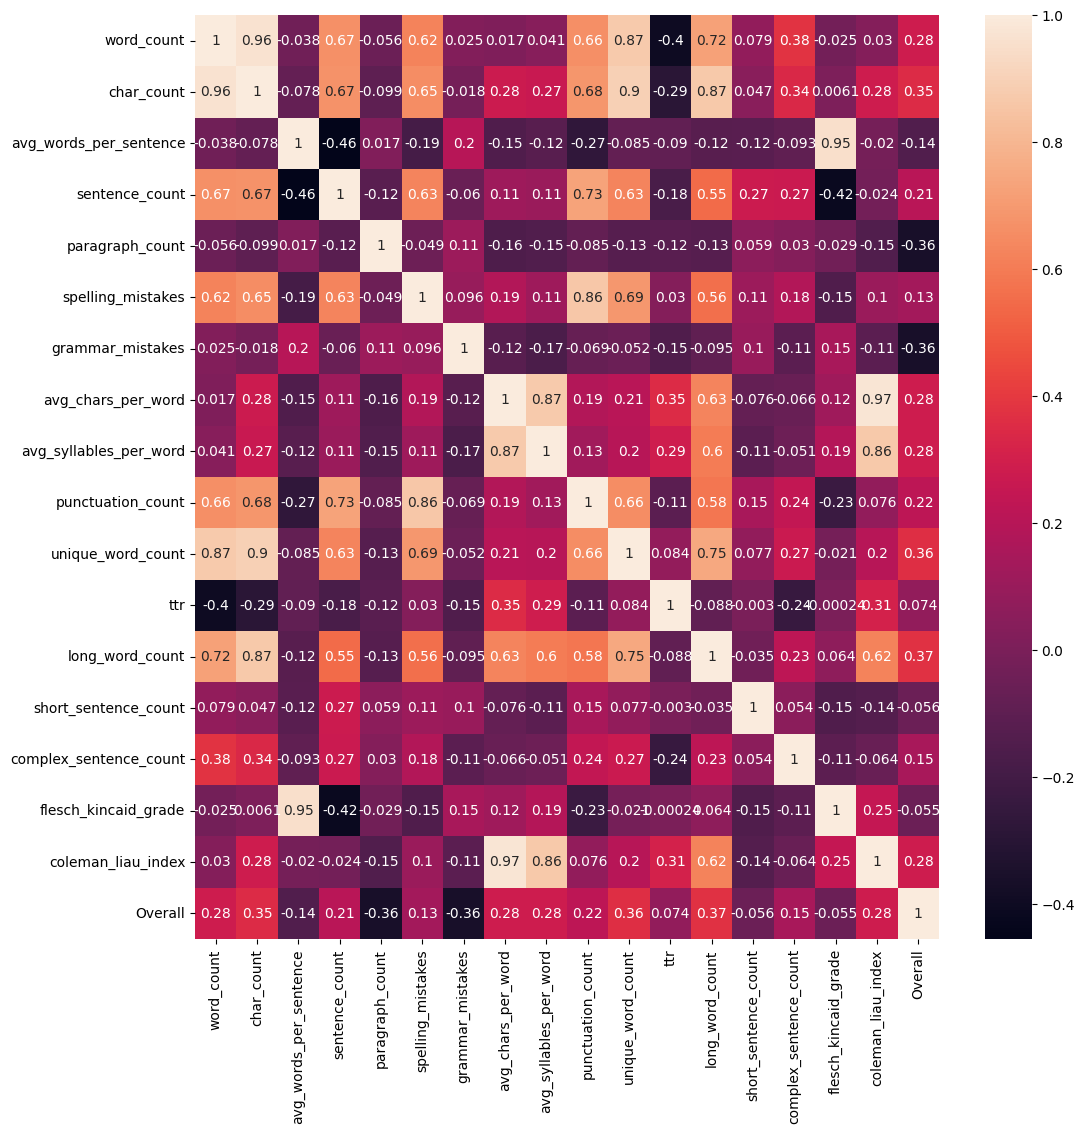

In [44]:
plt.figure(figsize=(12,12))
sns.heatmap(basic_df.corr(), annot=True);
plt.savefig('../plots/heatmap.png')
plt.show();

In [36]:
basic_df.corr()['Overall'].reset_index().sort_values(by='Overall', key=abs, ascending=False)

,index,Overall
17,Overall,1.000000
12,long_word_count,0.371260
6,grammar_mistakes,-0.361879
4,paragraph_count,-0.360389
10,unique_word_count,0.358081
1,char_count,0.346535
16,coleman_liau_index,0.282223
7,avg_chars_per_word,0.281620
0,word_count,0.279973
8,avg_syllables_per_word,0.279710


In [40]:
def categorize_score(score):
    if score <= 5:
        return 'Low'
    elif 5.5 <= score <= 7:
        return 'Medium'
    else:
        return 'Good'

basic_df['Score Category'] = basic_df['Overall'].apply(categorize_score)


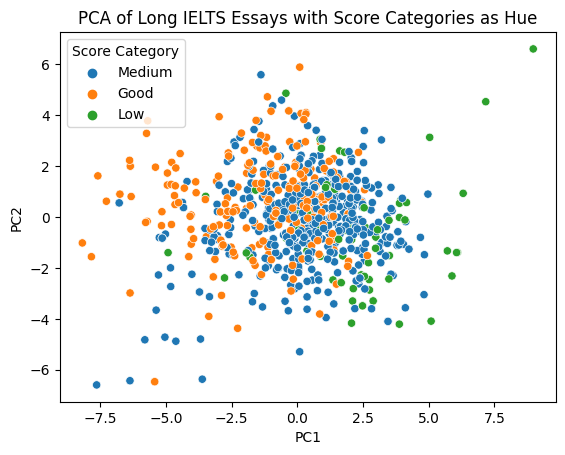

In [99]:
X = basic_df.drop(columns=['Question', 'Essay', 'Overall', 'Score Category'])   # Features
y = basic_df['Score Category']  # Categorical target

# Standardize the data before PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA and reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Convert PCA result into a DataFrame for easy plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Score Category'] = y.values  # Add the 'Score Category' column back for plotting

# Create a scatterplot of the two principal components with the new categories
sns.scatterplot(x='PC1', y='PC2', hue='Score Category', data=pca_df)

# Add plot title and labels
plt.title('PCA of Long IELTS Essays with Score Categories as Hue')
plt.savefig('../plots/scatterplot_pca.png')
plt.show()

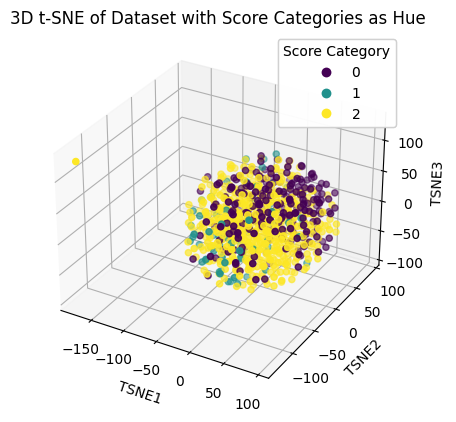

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'Overall' is the target column and 'Score Category' is now your categorical column
X = basic_df.drop(columns=['Question', 'Essay', 'Overall', 'Score Category'])  # Features
y = basic_df['Score Category']  # Categorical target

# Standardize the data before t-SNE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform t-SNE and reduce to 3 components
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Convert t-SNE result into a DataFrame for easy plotting
tsne_df = pd.DataFrame(data=X_tsne, columns=['TSNE1', 'TSNE2', 'TSNE3'])
tsne_df['Score Category'] = y.values  # Add the 'Score Category' column back for plotting

# Create a 3D scatterplot of the three t-SNE components with the new categories
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], tsne_df['TSNE3'], 
                     c=pd.Categorical(tsne_df['Score Category']).codes, cmap='viridis')

# Add plot title and labels
ax.set_title('3D t-SNE of Dataset with Score Categories as Hue')
ax.set_xlabel('TSNE1')
ax.set_ylabel('TSNE2')
ax.set_zlabel('TSNE3')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Score Category")
ax.add_artist(legend1)

# Save and show the plot
plt.savefig('../plots/3d_scatterplot_tsne.png')
plt.show()


# Using only the features with correlations of above 0.3

In [52]:
basic_df.corr()['Overall'].reset_index().sort_values(by='Overall', key=abs, ascending=False)['index']

/tmp/ipykernel_26742/3160661600.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  basic_df.corr()['Overall'].reset_index().sort_values(by='Overall', key=abs, ascending=False)['index']


17                   Overall
12           long_word_count
6           grammar_mistakes
4            paragraph_count
10         unique_word_count
1                 char_count
16        coleman_liau_index
7         avg_chars_per_word
0                 word_count
8     avg_syllables_per_word
9          punctuation_count
3             sentence_count
14    complex_sentence_count
2     avg_words_per_sentence
5          spelling_mistakes
11                       ttr
13      short_sentence_count
15      flesch_kincaid_grade
Name: index, dtype: object

In [55]:
top5_cols = ["long_word_count", "grammar_mistakes", "paragraph_count", "unique_word_count", "char_count", 'Overall', 'Score Category']
top5 =  basic_df[top5_cols].copy()

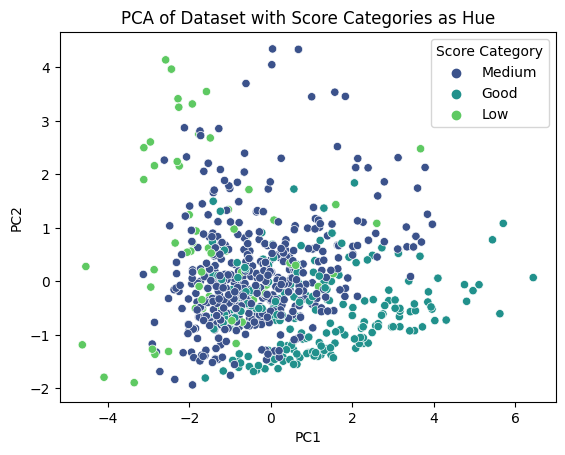

In [56]:

X = top5.drop(columns=['Overall', 'Score Category'])  # Features
y = top5['Score Category']  # Categorical target

# Standardize the data before PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA and reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Convert PCA result into a DataFrame for easy plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Score Category'] = y.values  # Add the 'Score Category' column back for plotting

# Create a scatterplot of the two principal components with the new categories
sns.scatterplot(x='PC1', y='PC2', hue='Score Category', data=pca_df, palette='viridis')

# Add plot title and labels
plt.title('PCA of Dataset with Score Categories as Hue')
plt.savefig('../plots/scatterplot_pca_top5.png')
plt.show()

In [71]:
basic_df.to_csv('../data/processed/ielts/long_essays.csv')

In [73]:
short_essays = df[mask2]
short_essays.columns

feature_extractor = FeatureExtractor()

short_df = feature_extractor.extract_features(short_essays, 'Essay')


  0%|          | 0/793 [00:00<?, ?it/s]

In [74]:
short_df['Overall'] = short_essays['Overall'].values
short_df[['Question', 'Essay']] = short_essays[['Question', 'Essay']]

In [75]:
short_df.to_csv('../data/processed/ielts/short_essays.csv')

In [81]:
basic_df['paragraph_count'].mean()

3.82093316519546

In [96]:
def categorize_score(score):
    if score <= 5:
        return 'Low'
    elif 5.5 <= score <= 7:
        return 'Medium'
    else:
        return 'Good'

short_df['Score Category'] = short_df['Overall'].apply(categorize_score)


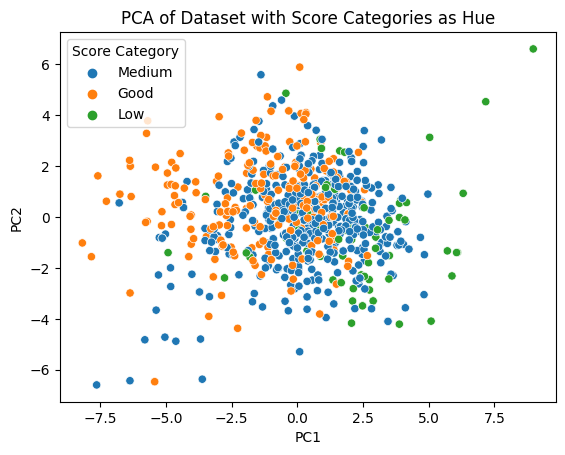

In [98]:
X = short_df.drop(columns=['Question', 'Essay', 'Overall', 'Score Category'])  # Features
y = short_df['Score Category']  # Categorical target

# Standardize the data before PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA and reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Convert PCA result into a DataFrame for easy plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Score Category'] = y.values  # Add the 'Score Category' column back for plotting

# Create a scatterplot of the two principal components with the new categories
sns.scatterplot(x='PC1', y='PC2', hue='Score Category', data=pca_df)

# Add plot title and labels
plt.title('PCA of Dataset with Score Categories as Hue')
plt.savefig('../plots/scatterplot_pca_small.png')
plt.show()

# Complex Features

In [11]:
from complex_features2 import ComplexFeatureExtractor

2024-10-18 12:47:52.821122: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-18 12:47:52.934261: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-18 12:47:52.968770: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-18 12:47:53.711741: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [13]:
def categorize_score(score):
    if score <= 5:
        return 'Low'
    elif 5.5 <= score <= 7:
        return 'Medium'
    else:
        return 'Good'

long_essays['Score Category'] =long_essays['Overall'].apply(categorize_score)


/tmp/ipykernel_23477/1346823584.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_essays['Score Category'] =long_essays['Overall'].apply(categorize_score)


In [14]:
long_essays

,Task_Type,Question,Essay,Examiner_Commen,Task_Response,Coherence_Cohesion,Lexical_Resource,Range_Accuracy,Overall,Score Category
1,2,Rich countries often give money to poorer coun...,Poverty represents a worldwide crisis. It is t...,NaN,NaN,NaN,NaN,NaN,6.5,Medium
3,2,Rich countries often give money to poorer coun...,Human beings are facing many challenges nowada...,NaN,NaN,NaN,NaN,NaN,5.5,Medium
5,2,Some countries achieve international sports by...,Whether countries should only invest facilitie...,NaN,NaN,NaN,NaN,NaN,6.5,Medium
7,2,Some countries achieve international sports by...,"Sports is an essential part to most of us , so...",NaN,NaN,NaN,NaN,NaN,5.5,Medium
9,2,Some countries achieve international sports by...,International sports events require the most w...,NaN,NaN,NaN,NaN,NaN,9.0,Good
...,...,...,...,...,...,...,...,...,...,...
1430,2,Without capital punishment our lives are less ...,Serious crimes need capital punishment so that...,"You should rewrite it, giving more thought to ...",NaN,NaN,NaN,NaN,5.0,Low
1431,2,Some people think that they can learn better b...,It is certainly said that learning is an ongoi...,Where are the paragraphs in this essay? You mu...,NaN,NaN,NaN,NaN,5.0,Low
1432,2,Nowadays people like to change their day by da...,popular hobbies rather than their individual a...,I suggest that you read several essays that ha...,NaN,NaN,NaN,NaN,5.0,Low
1433,2,Universities should allocate the same amount o...,"Yes, I do feel that universities should have a...","Your essay too short, the introduction is good...",NaN,NaN,NaN,NaN,5.0,Low


In [15]:
long_essays.reset_index(drop=True, inplace=True)

In [16]:
complex_feature_extractor = ComplexFeatureExtractor()

In [17]:
embeddings = complex_feature_extractor.transform(df=long_essays, text_column='Essay', model='bert')

  0%|          | 0/793 [00:00<?, ?it/s]

In [25]:
scores = [long_essays.loc[idx, 'Score Category'] for idx, _ in embeddings]
embeddings = [embedding for _, embedding in embeddings]

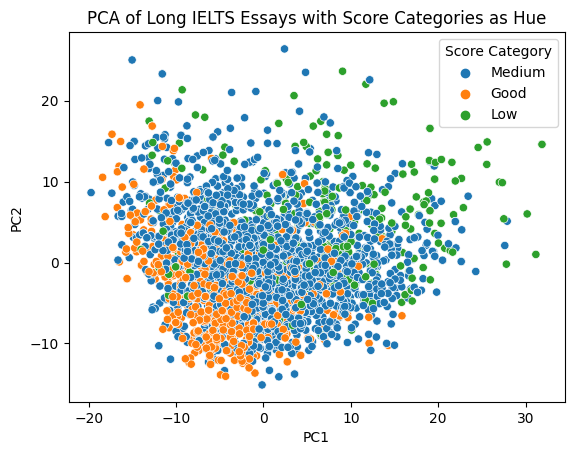

In [27]:
# Convert embeddings into a NumPy array for PCA
X = np.vstack(embeddings)

# Standardize the data before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA and reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Convert PCA result into a DataFrame for easy plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Score Category'] = scores  # Add the 'Score Category' column back for plotting

# Create a scatterplot of the two principal components with the new categories
sns.scatterplot(x='PC1', y='PC2', hue='Score Category', data=pca_df)

# Add plot title and labels
plt.title('PCA of Long IELTS Essays with Score Categories as Hue')
plt.savefig('../plots/scatterplot_pca_complex.png')
plt.show()

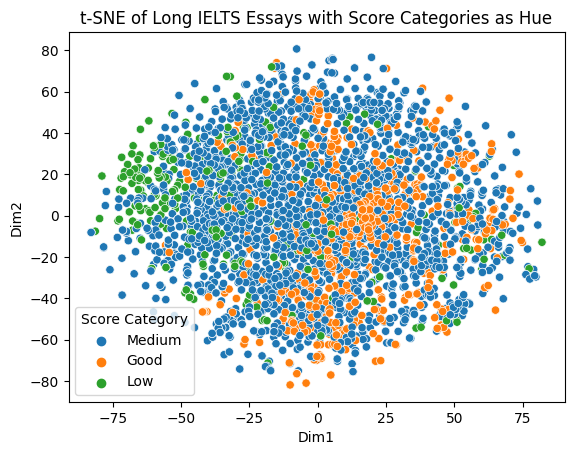

In [30]:


# # Convert embeddings into a NumPy array for t-SNE
# X = np.vstack(embeddings)

# # Standardize the data before t-SNE
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Perform t-SNE and reduce to 2 components
# tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
# X_tsne = tsne.fit_transform(X_scaled)

# # Convert t-SNE result into a DataFrame for easy plotting
# tsne_df = pd.DataFrame(data=X_tsne, columns=['Dim1', 'Dim2'])
# tsne_df['Score Category'] = scores  # Add the 'Score Category' column back for plotting

# # Create a scatterplot of the two t-SNE components with the new categories
sns.scatterplot(x='Dim1', y='Dim2', hue='Score Category', data=tsne_df)

# Add plot title and labels
plt.title('t-SNE of Long IELTS Essays with Score Categories as Hue')
plt.savefig('../plots/scatterplot_tsne.png')
plt.show()


In [36]:
long_essays.describe()

,Task_Type,Task_Response,Coherence_Cohesion,Lexical_Resource,Range_Accuracy,Overall
count,793.0,0.0,0.0,0.0,0.0,793.000000
mean,2.0,NaN,NaN,NaN,NaN,6.720050
std,0.0,NaN,NaN,NaN,NaN,1.087899
min,2.0,NaN,NaN,NaN,NaN,3.000000
25%,2.0,NaN,NaN,NaN,NaN,6.000000
50%,2.0,NaN,NaN,NaN,NaN,6.500000
75%,2.0,NaN,NaN,NaN,NaN,7.500000
max,2.0,NaN,NaN,NaN,NaN,9.000000


In [62]:
bad_mask = long_essays['Overall']<4
good_mask = (long_essays['Overall']>8.0)
long_essays[bad_mask].loc[124, 'Essay']

'there is no deying the fact the main requirement of goods it is debatable these days , which some people think the goods it is duty of supermarket , while others believe that responsibility of customers and really we have take a strict way for this issue , in this essay will dicuss both of side and will draw my personal experience , in one hand talking the group of people which but the refer guilty for supermarket and industry , when the products setting in the shop they empleoy of supermarket the must packaing off the goods after that they but them in store , so that why some think tha because it is this esay way when we dealing this proplomitc instaed we aviod , on the other hand it is another story here which the concept it is the custromer halt cunsume buy numres of pack for illustrated the must bring while shopping pack and do not taking from store in , addition even if we forgeat when we geting outdoor try reimend your self prior you go , hence the belife that is very essentail 

In [48]:
long_essays[bad_mask].loc[124, 'Question']

'Write about the following topic.Some people feel that manufacturers and supermarkets have the responsibility to reduce the amount of packaging of goods. Others argue that customers should avoid buying goods with a lot of packaging. Discuss both views and give your opinion.Give reasons for your answer and include any relevant examples from your own knowledge or experience.'

In [65]:
long_essays[good_mask].loc[139, 'Essay'].split('\n')[0]

'Most vehicles release a toxic amount of fumes into the atmosphere. This, in turn, has grown into an environmental issue of global concern that governments across the world believe can be mitigated by adding on to the price of fuels. I chiefly disagree with the effectiveness of this method as next to nothing had been altered since the policy enforcement due to convenience issues.'

In [67]:
# long_essays['Question'].value_counts()